# Analyzing Customer Churn for a Telecommunications Company 
<br> Objective: The objective of this project is to analyze customer churn for a telecommunications company and identify factors that contribute to customer attrition.
<br> Data: For this project, we will use the "Telco Customer Churn" dataset from Kaggle, which is a synthetic dataset representing customer data for a telecommunications company. 

## Data Preprocessing

In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the dataset
data = pd.read_csv('Telco-Customer-Churn.csv')

# Ensure 'Churn' and 'SeniorCitizen' are converted to 0 for 'No' and 1 for 'Yes'
data['Churn'] = data['Churn'].map({'No': 0, 'Yes': 1})
data["SeniorCitizen"]= data["SeniorCitizen"].map({0: "No", 1: "Yes"})

#Show the missing values 
def missing_values(n):
    df_m=pd.DataFrame()
    df_m["missing_values, %"]=data.isnull().sum()*100/len(data.isnull())
    df_m["missing_values, sum"]=data.isnull().sum()
    return df_m.sort_values(by="missing_values, %", ascending=False)
missing_values(data)

data['TotalCharges'] = pd.to_numeric(data.TotalCharges, errors='coerce')
data.isnull().sum()

data.drop(labels=data[data['tenure'] == 0].index, axis=0, inplace=True)
data[data['tenure'] == 0].index

data.fillna(data["TotalCharges"].mean())

# Convert categorical variables to numerical
data = pd.get_dummies(data, columns=['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'Contract', 'PaymentMethod'], drop_first=True)

def object_to_int(dataframe_series):
    if dataframe_series.dtype=='object':
        dataframe_series = LabelEncoder().fit_transform(dataframe_series)
    return dataframe_series
data = data.apply(lambda x: object_to_int(x))
# Split the data into training and testing sets
X = data.drop(columns = ['Churn'])
y = data['Churn'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.30, random_state = 40, stratify=y)

## Data Exploration and Visualization

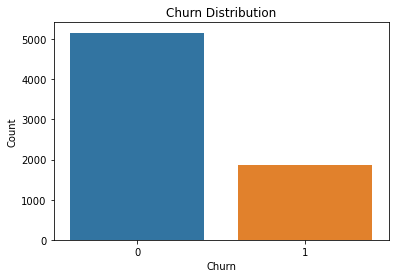

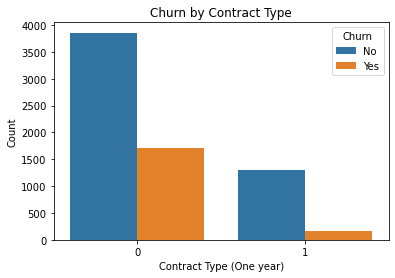

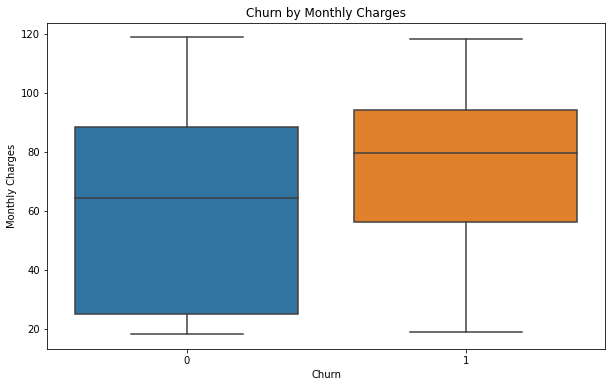

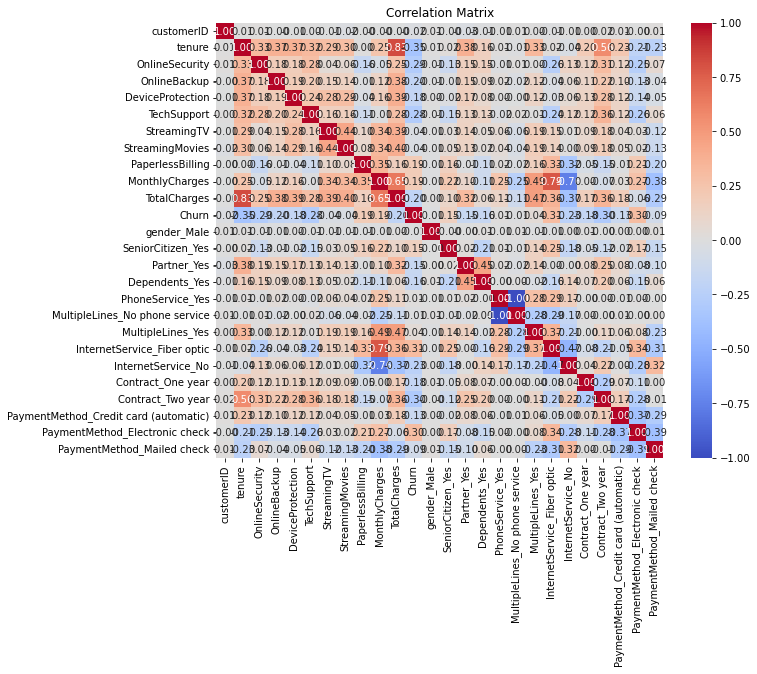

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Churn Distribution
sns.countplot(x='Churn', data=data)
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

# Churn by Contract Type
sns.countplot(x='Contract_One year', hue='Churn', data=data)
plt.title('Churn by Contract Type')
plt.xlabel('Contract Type (One year)')
plt.ylabel('Count')
plt.legend(title='Churn', labels=['No', 'Yes'])
plt.show()

# Churn by Monthly Charges
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='MonthlyCharges', data=data)
plt.title('Churn by Monthly Charges')
plt.xlabel('Churn')
plt.ylabel('Monthly Charges')
plt.show()

# Correlation Matrix
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()



## Data Analysis

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Select only numerical columns for standardization
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']  # Add other numerical columns if present

# Divide the columns into 3 categories, one ofor standardisation, one for label encoding and one for one hot encoding

cat_cols_ohe =['PaymentMethod', 'Contract', 'InternetService'] # those that need one-hot encoding
cat_cols_le = list(set(X_train.columns)- set(numerical_cols) - set(cat_cols_ohe)) #those that need label encoding

# Standardize the features (optional but often beneficial for some models)
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

knn_model = KNeighborsClassifier(n_neighbors = 11) 
knn_model.fit(X_train,y_train)
predicted_y = knn_model.predict(X_test)
accuracy_knn = knn_model.score(X_test,y_test)
print("KNN accuracy:",accuracy_knn)
print(classification_report(y_test, predicted_y))


KNN accuracy: 0.7241706161137441
              precision    recall  f1-score   support

           0       0.74      0.96      0.84      1549
           1       0.39      0.07      0.11       561

    accuracy                           0.72      2110
   macro avg       0.56      0.51      0.47      2110
weighted avg       0.65      0.72      0.64      2110



In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

model_rf = RandomForestClassifier(n_estimators=500 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features = "auto",
                                  max_leaf_nodes = 30)
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = model_rf.predict(X_test)
print (metrics.accuracy_score(y_test, prediction_test))
print(classification_report(y_test, prediction_test))

/Users/sherylshunlin/opt/miniconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


0.8099526066350711
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      1549
           1       0.71      0.49      0.58       561

    accuracy                           0.81      2110
   macro avg       0.77      0.71      0.73      2110
weighted avg       0.80      0.81      0.80      2110



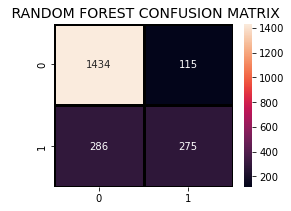

In [65]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, prediction_test),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title(" RANDOM FOREST CONFUSION MATRIX",fontsize=14)
plt.show()

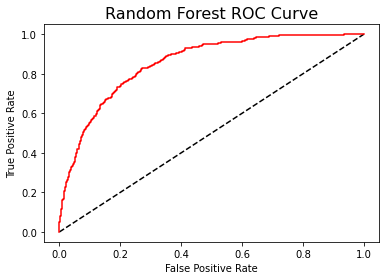

In [67]:
from sklearn.metrics import roc_curve
y_rfpred_prob = model_rf.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_rfpred_prob)
plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr_rf, tpr_rf, label='Random Forest',color = "r")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve',fontsize=16)
plt.show();